In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
import textstat

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from wordcloud import WordCloud
from collections import Counter
from gensim import corpora
from gensim.models import LdaModel

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/murat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/murat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/murat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/murat/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [45]:
# Load data
df = pd.read_csv('IMDB_Dataset.csv') 
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [46]:
# Check data size
print("Dataset Size:")
print(len(df))

Dataset Size:
50000


1- Data Exploration: Compute basic statistics (mean, median, min, max) for the length of the reviews (measured by the
number of words and characters).

In [47]:
# Add review length columns
df['word_count'] = df['review'].apply(lambda x: len(x.split()))
df['char_count'] = df['review'].apply(lambda x: len(x))

# Calculate basic statistics
print("Word Count Stats:")
print(df['word_count'].describe())

print("\nCharacter Count Stats:")
print(df['char_count'].describe())

Word Count Stats:
count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: word_count, dtype: float64

Character Count Stats:
count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: char_count, dtype: float64


1- Visualize the distribution of review lengths using histograms or box plots. Compare the
length of reviews for positive and negative sentiments.

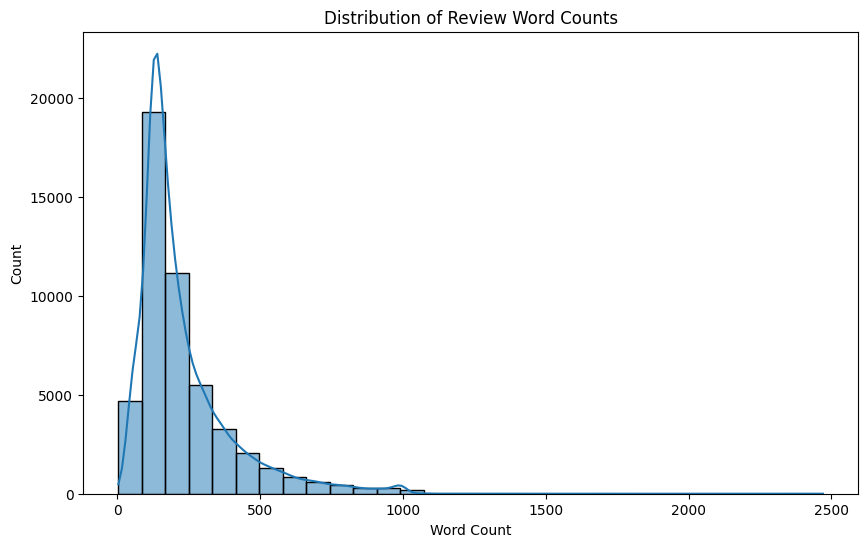

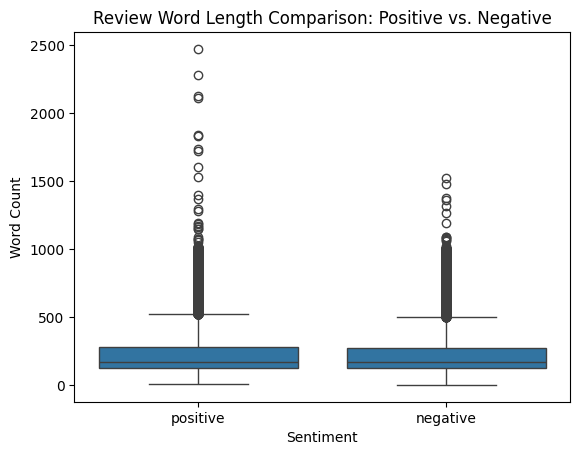

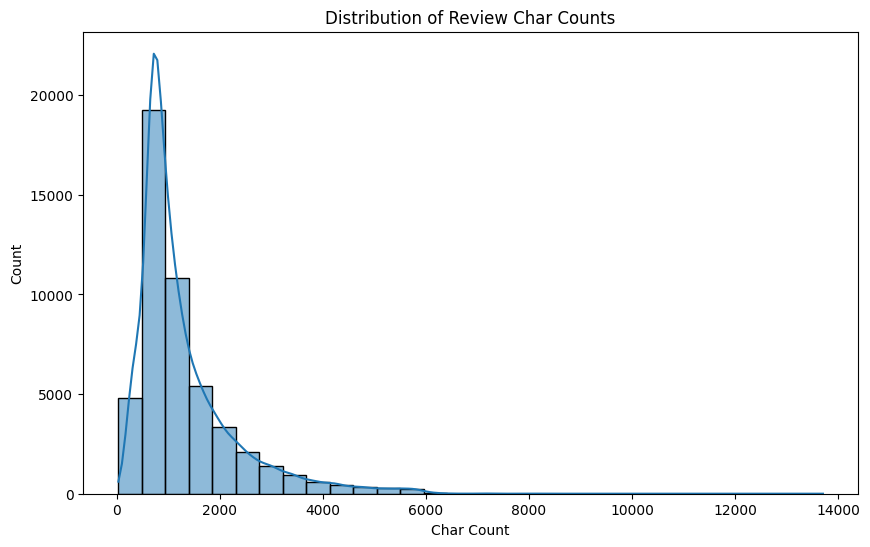

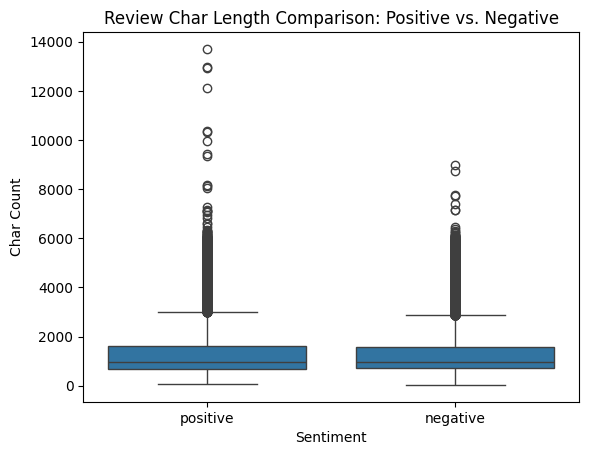

In [48]:
# Histograms for word count
plt.figure(figsize=(10,6))
sns.histplot(df['word_count'], bins=30, kde=True)
plt.title('Distribution of Review Word Counts')
plt.xlabel('Word Count')
plt.show()

# Box plot comparison for positive vs. negative reviews
sns.boxplot(x='sentiment', y='word_count', data=df)
plt.title('Review Word Length Comparison: Positive vs. Negative')
plt.ylabel('Word Count')
plt.xlabel('Sentiment')
plt.show()

# Histograms for char count
plt.figure(figsize=(10,6))
sns.histplot(df['char_count'], bins=30, kde=True)
plt.title('Distribution of Review Char Counts')
plt.xlabel('Char Count')
plt.show()

# Box plot comparison for positive vs. negative reviews
sns.boxplot(x='sentiment', y='char_count', data=df)
plt.title('Review Char Length Comparison: Positive vs. Negative')
plt.ylabel('Char Count')
plt.xlabel('Sentiment')
plt.show()

2- Data Cleaning: Perform standard text preprocessing tasks, including: Removing stop words, punctuation, and special
characters, Lowercasing the text, Tokenizing the reviews, Stemming or lemmatization.

# using lemmatization

In [49]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Remove URLs
    text = re.sub(r'http\S+', ' ', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove special characters and digits
    text = re.sub(r'\W|\d', ' ', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatizing
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
df['cleaned_review'] = df['review'].apply(preprocess_text)
df['cleaned_review']

0        one reviewer mentioned watching oz episode you...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically there family little boy jake think t...
4        petter matteis love time money visually stunni...
                               ...                        
49995    thought movie right good job wasnt creative or...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary school nu...
49998    im going disagree previous comment side maltin...
49999    one expects star trek movie high art fan expec...
Name: cleaned_review, Length: 50000, dtype: object

3- Review Word Frequency Analysis:

In [51]:
# Recompute the length of the reviews after pre processing
df['word_count'] = df['cleaned_review'].apply(lambda x: len(x.split()))
df['char_count'] = df['cleaned_review'].apply(lambda x: len(x))

In [52]:
# Separate positive and negative reviews
positive_reviews = df[df['sentiment'] == 'positive']['cleaned_review']
negative_reviews = df[df['sentiment'] == 'negative']['cleaned_review']

3.1- Most Common Words: Generate a word frequency count for both the positive and
negative reviews. Visualize the most frequent words using word clouds and bar charts, with separate visualizations for positive
and negative reviews.

In [53]:
# Function to get word frequency
def get_word_frequencies(text):
    words = ' '.join(text).split()
    word_count = Counter(words)
    return word_count

# Get word frequencies for positive and negative reviews
positive_word_freq = get_word_frequencies(positive_reviews)
negative_word_freq = get_word_frequencies(negative_reviews)

# Convert to DataFrame for easier viewing and sorting
positive_word_freq_df = pd.DataFrame(positive_word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
negative_word_freq_df = pd.DataFrame(negative_word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Display top 10 most common words for each
print("Top 10 words in Positive Reviews:")
print(positive_word_freq_df.head(10))

print("\nTop 10 words in Negative Reviews:")
print(negative_word_freq_df.head(10))

Top 10 words in Positive Reviews:
          Word  Frequency
276       film      48758
285      movie      43931
0          one      27538
383       like      17668
206       time      15641
334       good      14642
358      story      13913
219  character      13828
175      great      12860
162        see      12652

Top 10 words in Negative Reviews:
          Word  Frequency
12       movie      57037
26        film      42825
100        one      26280
34        like      22358
274       even      15103
11        time      14613
374       good      14388
77         bad      14377
182  character      14157
187      would      13653


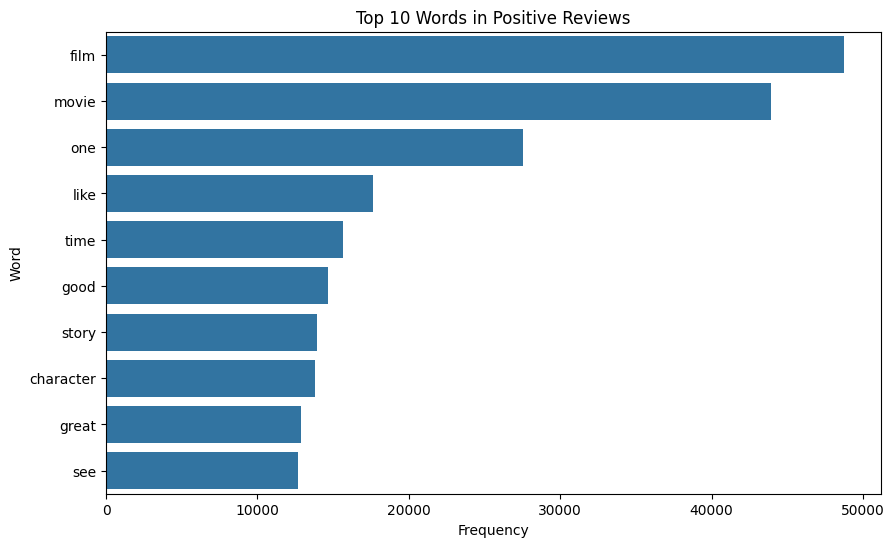

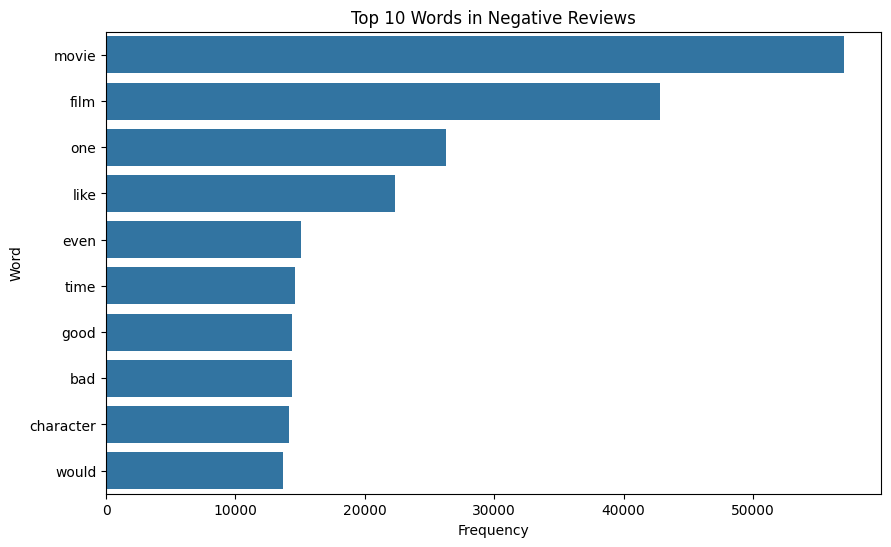

In [54]:
# Function to plot top words
def plot_top_words(word_freq_df, title):
    top_words = word_freq_df.head(10)
    plt.figure(figsize=(10,6))
    sns.barplot(x='Frequency', y='Word', data=top_words)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.show()

# Plot top words for positive and negative reviews
plot_top_words(positive_word_freq_df, 'Top 10 Words in Positive Reviews')
plot_top_words(negative_word_freq_df, 'Top 10 Words in Negative Reviews')

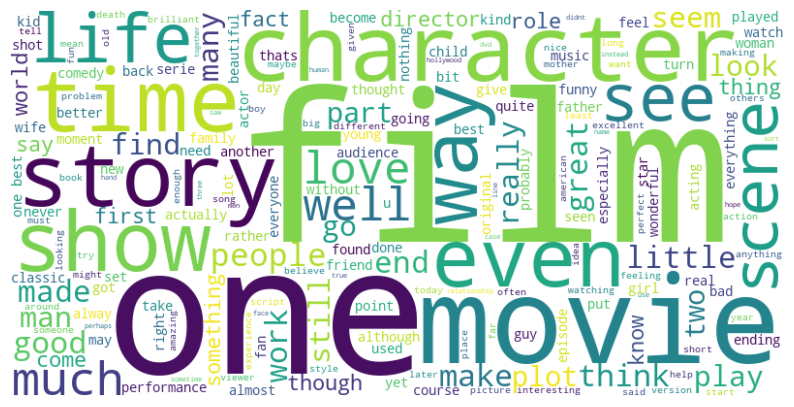

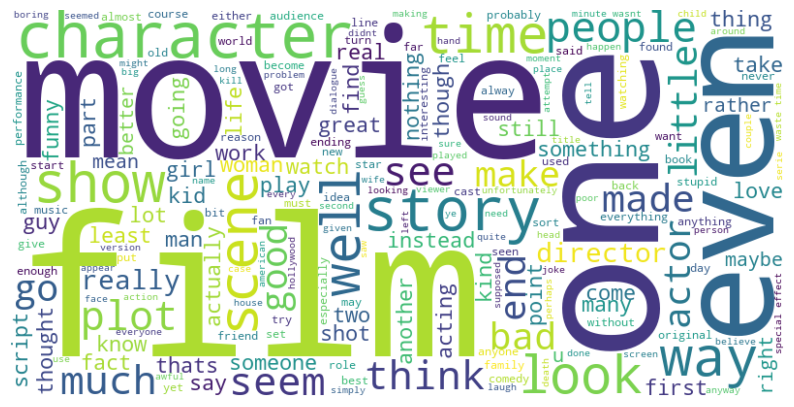

In [55]:
# Generate word cloud
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

generate_wordcloud(positive_reviews)
generate_wordcloud(negative_reviews)

3.2- N-gram Analysis: Explore bi-grams and tri-grams (two- and three-word combinations) to
uncover common phrases in the reviews. Separate this analysis for positive and negative reviews to observe any recurring
phrases that indicate strong sentiment.

In [56]:
# Function to get n-grams
def get_top_ngrams(corpus, n=2, top_n=10):

    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    ngram_freq = vec.transform(corpus)
    sum_ngrams = ngram_freq.sum(axis=0)
    
    # Get n-grams and their frequencies
    ngrams = [(ngram, sum_ngrams[0, idx]) for ngram, idx in vec.vocabulary_.items()]
    ngrams = sorted(ngrams, key=lambda x: x[1], reverse=True)[:top_n]
    
    # Convert to DataFrame for easier viewing
    ngram_df = pd.DataFrame(ngrams, columns=['N-gram', 'Frequency'])
    return ngram_df

# Example usage:
positive_bigrams = get_top_ngrams(positive_reviews, n=2, top_n=10)
negative_bigrams = get_top_ngrams(negative_reviews, n=2, top_n=10)

positive_trigrams = get_top_ngrams(positive_reviews, n=3, top_n=10)
negative_trigrams = get_top_ngrams(negative_reviews, n=3, top_n=10)

In [57]:
# Display results
print("Top 10 Bi-grams in Positive Reviews:")
print(positive_bigrams)

print("\nTop 10 Bi-grams in Negative Reviews:")
print(negative_bigrams)

Top 10 Bi-grams in Positive Reviews:
           N-gram  Frequency
0        ive seen       1552
1       dont know        904
2      movie like        846
3        new york        842
4  main character        835
5        year old        825
6  special effect        796
7     great movie        784
8       look like        775
9      good movie        769

Top 10 Bi-grams in Negative Reviews:
           N-gram  Frequency
0       look like       2221
1        ive seen       1898
2  special effect       1438
3      waste time       1429
4       dont know       1309
5       bad movie       1237
6      movie like       1157
7     worst movie       1148
8  main character       1075
9    horror movie       1009


In [58]:
print("\nTop 10 Tri-grams in Positive Reviews:")
print(positive_trigrams)

print("\nTop 10 Tri-grams in Negative Reviews:")
print(negative_trigrams)


Top 10 Tri-grams in Positive Reviews:
                        N-gram  Frequency
0                film ive seen        236
1               movie ive seen        222
2                new york city        193
3                 world war ii        157
4             based true story        138
5               ive seen movie         96
6               seen long time         91
7       highly recommend movie         87
8  international film festival         82
9        highly recommend film         68

Top 10 Tri-grams in Negative Reviews:
                N-gram  Frequency
0       movie ive seen        422
1      dont waste time        369
2     worst movie seen        321
3      worst movie ive        236
4        film ive seen        217
5     waste time money        181
6      worst film seen        150
7    doesnt make sense        132
8       bad acting bad        126
9  complete waste time        122


4- Correlation Between Review Length and Sentiment: Calculate the correlation between sentiment and review length and
analyze whether longer or shorter reviews tend to be positive or negative.

In [59]:
# Convert sentiment to numeric values: 1 for positive, 0 for negative
df['sentiment_numeric'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Calculate the correlation between sentiment and review length (word count)
correlation = df['sentiment_numeric'].corr(df['word_count'])
print(f"Correlation between sentiment and review length: {correlation:.2f}")

Correlation between sentiment and review length: 0.02


4-Plot the average review length for positive and
negative reviews to explore potential patterns.

In [60]:
# Calculate average review length for positive and negative reviews
average_length_positive = df[df['sentiment'] == 'positive']['word_count'].mean()
average_length_negative = df[df['sentiment'] == 'negative']['word_count'].mean()

print(f"Average Review Length (Positive): {average_length_positive:.2f} words")
print(f"Average Review Length (Negative): {average_length_negative:.2f} words")

Average Review Length (Positive): 120.34 words
Average Review Length (Negative): 117.61 words


/var/folders/xz/tpjwm4l52hjdcg11dtxxgyxr0000gn/T/ipykernel_61270/1048062033.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='Average Word Count', data=avg_length_df, palette='viridis')


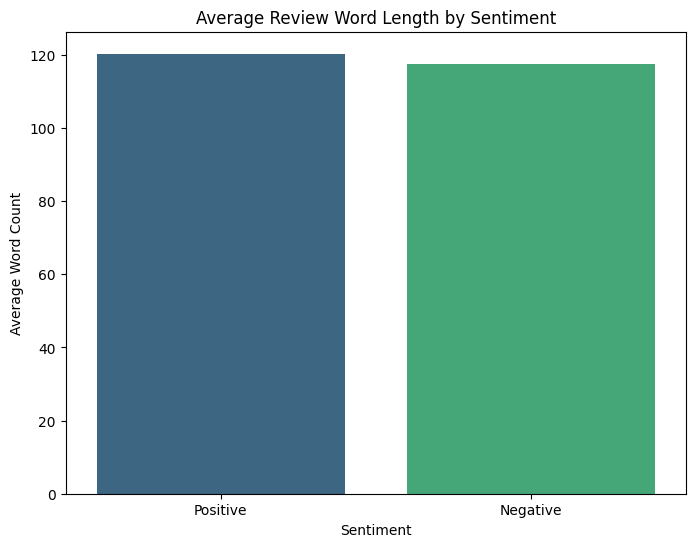

In [61]:
# Create a DataFrame for visualization
avg_length_df = pd.DataFrame({
    'Sentiment': ['Positive', 'Negative'],
    'Average Word Count': [average_length_positive, average_length_negative]
})

# Plot the average review length
plt.figure(figsize=(8, 6))
sns.barplot(x='Sentiment', y='Average Word Count', data=avg_length_df, palette='viridis')
plt.title('Average Review Word Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Word Count')
plt.show()

5- Review Complexity Analysis: Calculate readability metrics such as the Flesch-Kincaid or Gunning Fog Index for each
review to assess its complexity. This analysis explores whether there is a correlation between the complexity of the review
and its sentiment (e.g., do more complex reviews tend to be positive or negative?).

In [62]:
# Function to calculate Flesch-Kincaid Grade Level and Gunning Fog Index
def calculate_readability_metrics(text):
    fk_grade = textstat.flesch_kincaid_grade(text)
    fog_index = textstat.gunning_fog(text)
    return fk_grade, fog_index

# Apply functions to each review
df['flesch_kincaid_grade'], df['gunning_fog_index'] = zip(*df['cleaned_review'].apply(calculate_readability_metrics))

# Show a sample of the DataFrame
df[['cleaned_review', 'flesch_kincaid_grade', 'gunning_fog_index', 'sentiment']].head()

,cleaned_review,flesch_kincaid_grade,gunning_fog_index,sentiment
0,one reviewer mentioned watching oz episode you...,68.0,70.98,positive
1,wonderful little production filming technique ...,40.8,43.12,positive
2,thought wonderful way spend time hot summer we...,37.6,41.53,positive
3,basically there family little boy jake think t...,30.6,32.17,negative
4,petter matteis love time money visually stunni...,53.2,55.44,positive


5- Also, lexical diversity, which is the ratio
of unique words to total words, will be measured for each review. The lexical diversity of positive and negative reviews will
then be compared to identify any differences in language richness between the two sentiment classes.

In [63]:
def lexical_diversity(text):
    words = text.split()
    return len(set(words)) / len(words)

df['lexical_diversity'] = df['cleaned_review'].apply(lexical_diversity)


In [64]:
# Calculate correlations
fk_correlation = df['flesch_kincaid_grade'].corr(df['sentiment_numeric'])
fog_correlation = df['gunning_fog_index'].corr(df['sentiment_numeric'])
lexical_diversity_correlation = df['lexical_diversity'].corr(df['sentiment_numeric'])

print(f"Correlation between Flesch-Kincaid Grade Level and Sentiment: {fk_correlation:.2f}")
print(f"Correlation between Gunning Fog Index and Sentiment: {fog_correlation:.2f}")
print(f"Correlation between Lexical Diversity and Sentiment: {lexical_diversity_correlation:.2f}")

Correlation between Flesch-Kincaid Grade Level and Sentiment: 0.02
Correlation between Gunning Fog Index and Sentiment: 0.02
Correlation between Lexical Diversity and Sentiment: -0.03


Average Lexical Diversity (Positive): 0.84
Average Lexical Diversity (Negative): 0.85


/var/folders/xz/tpjwm4l52hjdcg11dtxxgyxr0000gn/T/ipykernel_61270/2719445389.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='Average Lexical Diversity', data=avg_lexical_diversity_df, palette='viridis')


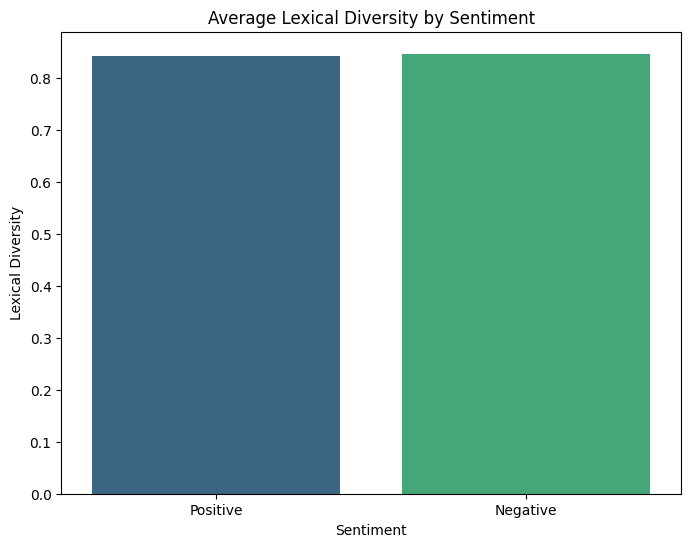

In [65]:
# Calculate average lexical diversity for positive and negative reviews
avg_lexical_diversity_positive = df[df['sentiment'] == 'positive']['lexical_diversity'].mean()
avg_lexical_diversity_negative = df[df['sentiment'] == 'negative']['lexical_diversity'].mean()

print(f"Average Lexical Diversity (Positive): {avg_lexical_diversity_positive:.2f}")
print(f"Average Lexical Diversity (Negative): {avg_lexical_diversity_negative:.2f}")

# Visualize lexical diversity comparison
avg_lexical_diversity_df = pd.DataFrame({
    'Sentiment': ['Positive', 'Negative'],
    'Average Lexical Diversity': [avg_lexical_diversity_positive, avg_lexical_diversity_negative]
})

plt.figure(figsize=(8, 6))
sns.barplot(x='Sentiment', y='Average Lexical Diversity', data=avg_lexical_diversity_df, palette='viridis')
plt.title('Average Lexical Diversity by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Lexical Diversity')
plt.show()

6- Part-of-Speech (POS) Tagging Analysis: Apply POS tagging to the text data to categorize words into grammatical
categories such as nouns, verbs, adjectives, etc. The aim is to explore the frequency and distribution of various parts of speech
in both positive and negative reviews. For instance, investigate whether adjectives and adverbs, which often convey sentiment,
occur more frequently in positive reviews compared to negative ones.

In [66]:
# Function to perform POS tagging and count frequencies of POS categories
def pos_tag_analysis(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Perform POS tagging
    pos_tags = nltk.pos_tag(tokens)
    # Count POS categories
    pos_counts = {
        'nouns': 0,
        'verbs': 0,
        'adjectives': 0,
        'adverbs': 0
    }
    for word, tag in pos_tags:
        if tag.startswith('NN'):  # Noun
            pos_counts['nouns'] += 1
        elif tag.startswith('VB'):  # Verb
            pos_counts['verbs'] += 1
        elif tag.startswith('JJ'):  # Adjective
            pos_counts['adjectives'] += 1
        elif tag.startswith('RB'):  # Adverb
            pos_counts['adverbs'] += 1
    
    return pos_counts

# Apply the function to each review and store results in new columns
df[['nouns', 'verbs', 'adjectives', 'adverbs']] = df['cleaned_review'].apply(lambda x: pd.Series(pos_tag_analysis(x)))

# Show a sample of the DataFrame
df[['cleaned_review', 'nouns', 'verbs', 'adjectives', 'adverbs', 'sentiment']].head()

,cleaned_review,nouns,verbs,adjectives,adverbs,sentiment
0,one reviewer mentioned watching oz episode you...,78,33,40,10,positive
1,wonderful little production filming technique ...,33,18,20,11,positive
2,thought wonderful way spend time hot summer we...,39,19,18,6,positive
3,basically there family little boy jake think t...,32,13,12,5,negative
4,petter matteis love time money visually stunni...,61,23,29,5,positive


In [67]:
# Calculate average counts of POS categories for positive and negative reviews
avg_pos_positive = df[df['sentiment'] == 'positive'][['nouns', 'verbs', 'adjectives', 'adverbs']].mean()
avg_pos_negative = df[df['sentiment'] == 'negative'][['nouns', 'verbs', 'adjectives', 'adverbs']].mean()

# Combine into a DataFrame for easier comparison
avg_pos_df = pd.DataFrame({
    'POS': ['Nouns', 'Verbs', 'Adjectives', 'Adverbs'],
    'Positive': avg_pos_positive.values,
    'Negative': avg_pos_negative.values
})

print(avg_pos_df)

          POS  Positive  Negative
0       Nouns  55.19808  52.80984
1       Verbs  22.11672  22.50708
2  Adjectives  26.09332  24.90644
3     Adverbs  10.51648  10.62312


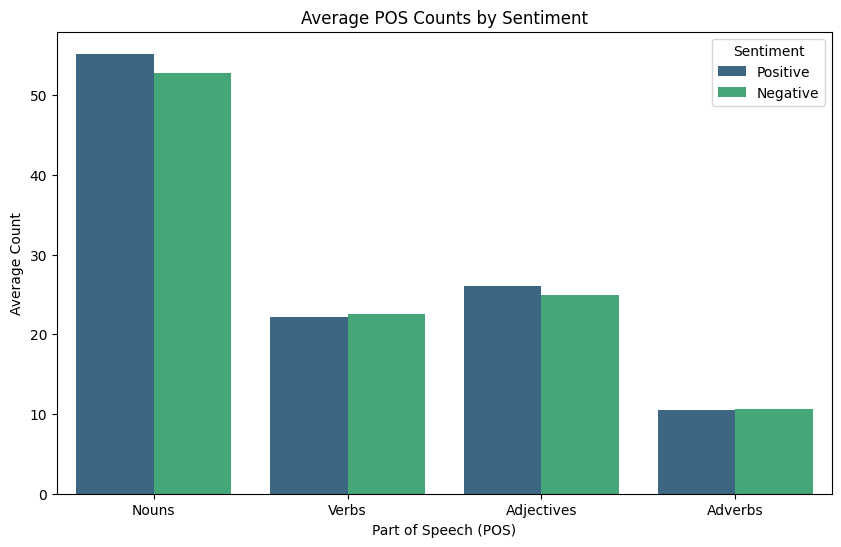

In [68]:
# Melt DataFrame for plotting
avg_pos_melted = avg_pos_df.melt(id_vars='POS', value_vars=['Positive', 'Negative'], var_name='Sentiment', value_name='Average Count')

# Plot the average POS counts
plt.figure(figsize=(10, 6))
sns.barplot(x='POS', y='Average Count', hue='Sentiment', data=avg_pos_melted, palette='viridis')
plt.title('Average POS Counts by Sentiment')
plt.xlabel('Part of Speech (POS)')
plt.ylabel('Average Count')
plt.show()

7- Sentiment Analysis on Review Topics: Using topic modeling techniques such as Latent Dirichlet Allocation (LDA),
identify the main topics in the reviews. After identifying these topics, analyze the sentiment of the reviews within each topic
to determine if specific topics tend to evoke more positive or negative sentiment.

In [69]:
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Apply preprocessing to all reviews
df['tokens'] = df['cleaned_review'].apply(tokenize_text)

In [70]:
# Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

In [71]:
# Set number of topics
num_topics = 5

# Train the LDA model
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# Print the topics
topics = lda_model.print_topics(num_words=5)
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

Topic 0: 0.020*"song" + 0.011*"music" + 0.011*"musical" + 0.011*"animation" + 0.009*"cartoon"
Topic 1: 0.008*"one" + 0.008*"film" + 0.007*"get" + 0.006*"horror" + 0.006*"scene"
Topic 2: 0.008*"show" + 0.006*"war" + 0.005*"one" + 0.005*"life" + 0.005*"year"
Topic 3: 0.031*"film" + 0.009*"one" + 0.008*"character" + 0.008*"story" + 0.005*"movie"
Topic 4: 0.044*"movie" + 0.013*"like" + 0.012*"film" + 0.012*"one" + 0.010*"good"


In [72]:
# Function to get the dominant topic for each review
def get_dominant_topic(lda_model, bow):
    topics = lda_model[bow]
    dominant_topic = max(topics, key=lambda x: x[1])[0]
    return dominant_topic

# Apply the function to get the dominant topic for each review
df['dominant_topic'] = [get_dominant_topic(lda_model, bow) for bow in corpus]

In [73]:
# Group by topic and sentiment to see distribution
topic_sentiment_distribution = df.groupby(['dominant_topic', 'sentiment']).size().unstack().fillna(0)
topic_sentiment_distribution['Total'] = topic_sentiment_distribution.sum(axis=1)

# Calculate percentage of positive and negative reviews for each topic
topic_sentiment_distribution['Positive %'] = (topic_sentiment_distribution['positive'] / topic_sentiment_distribution['Total']) * 100
topic_sentiment_distribution['Negative %'] = (topic_sentiment_distribution['negative'] / topic_sentiment_distribution['Total']) * 100

print(topic_sentiment_distribution[['Positive %', 'Negative %']])

sentiment       Positive %  Negative %
dominant_topic                        
0                95.918367    4.081633
1                31.909846   68.090154
2                70.997680   29.002320
3                70.709298   29.290702
4                36.503105   63.496895


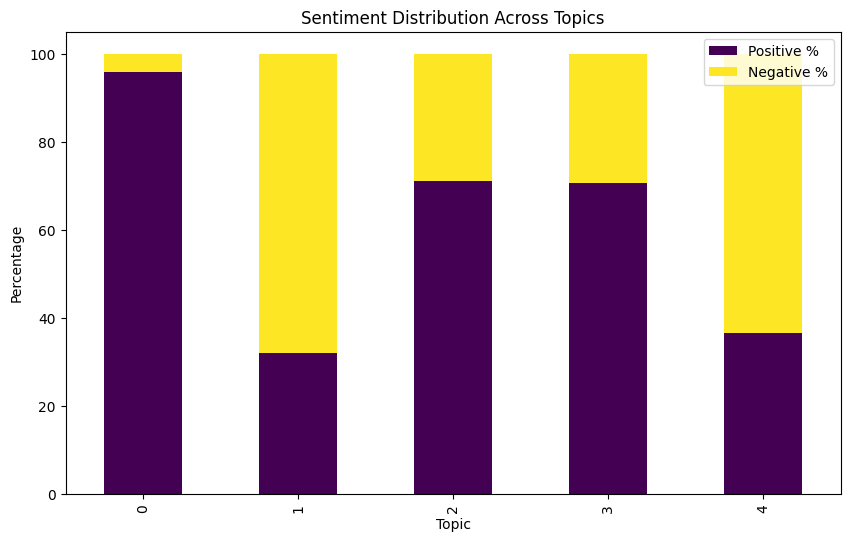

In [74]:
# Visualize sentiment distribution for each topic
topic_sentiment_distribution[['Positive %', 'Negative %']].plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Sentiment Distribution Across Topics')
plt.xlabel('Topic')
plt.ylabel('Percentage')
plt.legend(loc='upper right')
plt.show()

8- Comparison of Pre-Trained Sentiment Models with Ground Truth Labels: Use pre-trained models like VADER and
TextBlob to analyze the sentiment of the reviews, assigning a sentiment polarity score (positive, and negative) to each review.
To compare these sentiment scores with the ground truth labels (positive or negative) in the dataset, create a confusion matrix
to assess how well the pre-trained models align with the true labels. Calculate evaluation metrics such as accuracy, precision,
recall, and F1-score for both VADER and TextBlob. Additionally, visualize the distribution of sentiment polarity scores
generated by these models for both the positive and negative labeled reviews to identify any discrepancies between the model
predictions and the actual labels. Use bar plots or stacked bar plots to show the agreement or disagreement between the pre-
trained models’ polarity scores and the true sentiment labels. Also, conduct an error analysis to inspect cases where the pre-trained models significantly differ from the ground truth (e.g., reviews labeled as positive but classified as negative by
VADER), and discuss patterns or common characteristics of reviews where these models perform poorly, such as sarcasm or
ambiguous language.

In [75]:
# Initialize VADER Sentiment Analyzer
vader_analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment using VADER
def vader_sentiment(review):
    score = vader_analyzer.polarity_scores(review)['compound']
    return 'positive' if score >= 0 else 'negative'

# Apply VADER to classify reviews
df['vader_sentiment'] = df['cleaned_review'].apply(vader_sentiment)

In [76]:
# Function to classify sentiment using TextBlob
def textblob_sentiment(review):
    score = TextBlob(review).sentiment.polarity
    return 'positive' if score >= 0 else 'negative'

# Apply TextBlob to classify reviews
df['textblob_sentiment'] = df['cleaned_review'].apply(textblob_sentiment)

VADER Evaluation:
Accuracy: 0.68
Precision: 0.63
Recall: 0.87
F1-Score: 0.73


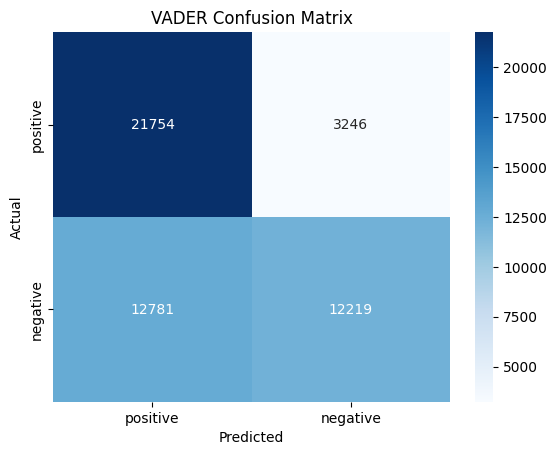

TextBlob Evaluation:
Accuracy: 0.70
Precision: 0.64
Recall: 0.93
F1-Score: 0.76


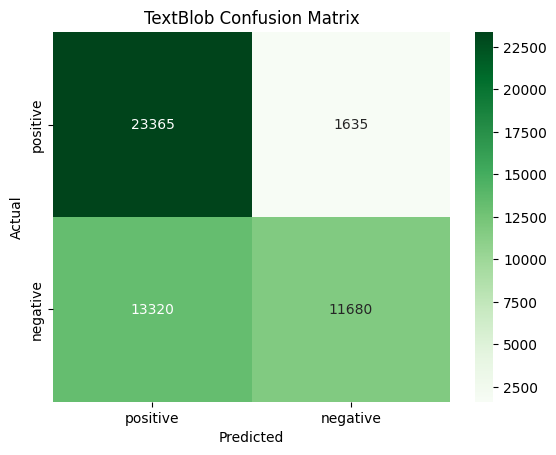

In [77]:
# Function to print evaluation metrics
def evaluate_model(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, pos_label='positive')
    recall = recall_score(true_labels, predicted_labels, pos_label='positive')
    f1 = f1_score(true_labels, predicted_labels, pos_label='positive')
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

# Evaluate VADER
print("VADER Evaluation:")
evaluate_model(df['sentiment'], df['vader_sentiment'])

# Confusion matrix for VADER
vader_cm = confusion_matrix(df['sentiment'], df['vader_sentiment'], labels=['positive', 'negative'])
sns.heatmap(vader_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
plt.title("VADER Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Evaluate TextBlob
print("TextBlob Evaluation:")
evaluate_model(df['sentiment'], df['textblob_sentiment'])

# Confusion matrix for TextBlob
textblob_cm = confusion_matrix(df['sentiment'], df['textblob_sentiment'], labels=['positive', 'negative'])
sns.heatmap(textblob_cm, annot=True, fmt='d', cmap='Greens', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
plt.title("TextBlob Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

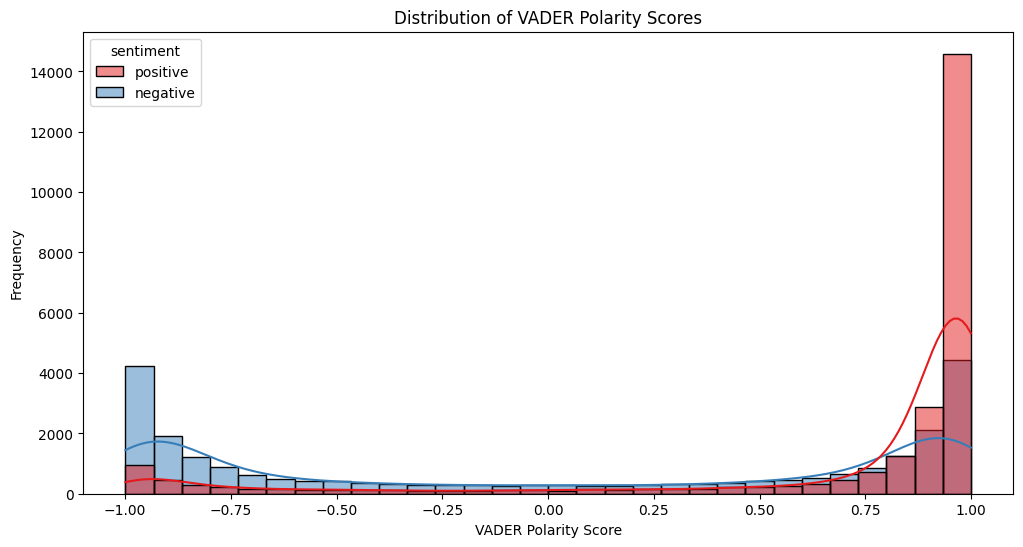

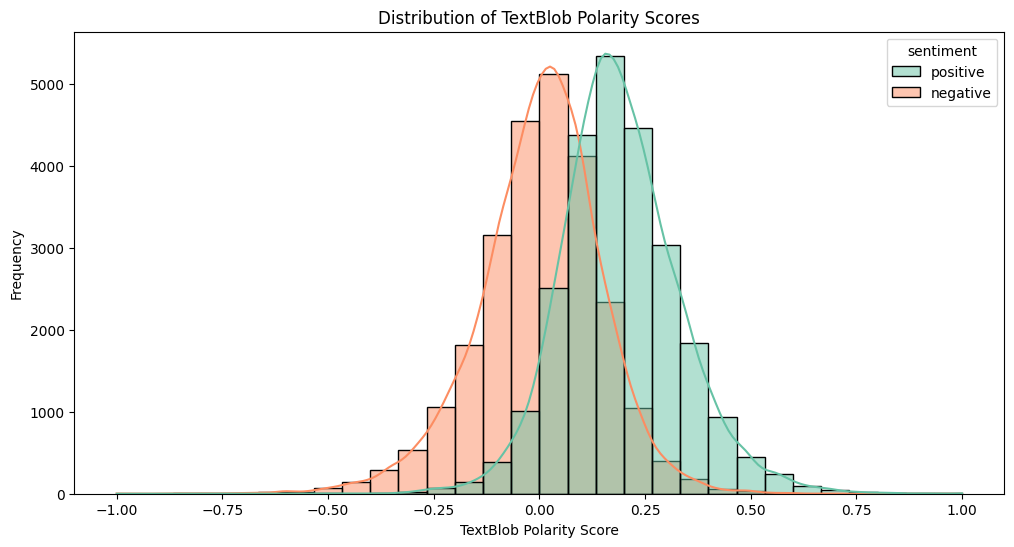

In [78]:
# Function to get VADER polarity scores
df['vader_polarity'] = df['cleaned_review'].apply(lambda x: vader_analyzer.polarity_scores(x)['compound'])
df['textblob_polarity'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Visualize polarity score distributions
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='vader_polarity', hue='sentiment', kde=True, palette='Set1', bins=30)
plt.title('Distribution of VADER Polarity Scores')
plt.xlabel('VADER Polarity Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='textblob_polarity', hue='sentiment', kde=True, palette='Set2', bins=30)
plt.title('Distribution of TextBlob Polarity Scores')
plt.xlabel('TextBlob Polarity Score')
plt.ylabel('Frequency')
plt.show()

In [79]:
# Extract misclassified reviews by VADER
vader_misclassified = df[(df['sentiment'] != df['vader_sentiment'])]
print("Examples of Misclassified Reviews by VADER:")
print(vader_misclassified[['review', 'sentiment', 'vader_sentiment']].head())

# Extract misclassified reviews by TextBlob
textblob_misclassified = df[(df['sentiment'] != df['textblob_sentiment'])]
print("Examples of Misclassified Reviews by TextBlob:")
print(textblob_misclassified[['review', 'sentiment', 'textblob_sentiment']].head())

# Analyze common patterns
vader_negative_as_positive = vader_misclassified[(vader_misclassified['sentiment'] == 'negative') & (vader_misclassified['vader_sentiment'] == 'positive')]
vader_positive_as_negative = vader_misclassified[(vader_misclassified['sentiment'] == 'positive') & (vader_misclassified['vader_sentiment'] == 'negative')]

# Count and analyze patterns
print(f"VADER Negative as Positive: {len(vader_negative_as_positive)}")
print(f"VADER Positive as Negative: {len(vader_positive_as_negative)}")

Examples of Misclassified Reviews by VADER:
                                               review sentiment  \
0   One of the other reviewers has mentioned that ...  positive   
7   This show was an amazing, fresh & innovative i...  negative   
10  Phil the Alien is one of those quirky films wh...  negative   
12  So im not a big fan of Boll's work but then ag...  negative   
13  The cast played Shakespeare.<br /><br />Shakes...  negative   

   vader_sentiment  
0         negative  
7         positive  
10        positive  
12        positive  
13        positive  
Examples of Misclassified Reviews by TextBlob:
                                               review sentiment  \
3   Basically there's a family where a little boy ...  negative   
7   This show was an amazing, fresh & innovative i...  negative   
10  Phil the Alien is one of those quirky films wh...  negative   
11  I saw this movie when I was about 12 when it c...  negative   
12  So im not a big fan of Boll's work but th

In [80]:
# Save pre processed dataset to a file for further tasks
df.to_csv('IMDB_Dataset_Preprocessed.csv')